In [10]:
import glob
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction import stop_words
import math
import re
import string
import nltk
from nltk import tokenize, sent_tokenize

print("Packages imported")

C:\Users\jacob\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Packages imported


# Exploratory Data Analysis

# 1.1 Get Data

In [11]:
# Done in command line

# 1.2 Load Data

In [12]:
ndf = pd.DataFrame(columns=["filename",'text'])
path = "C:\\Users\\jacob\\OneDrive\\Desktop\\GitHub\\Deep-Learning-for-NLP-and-Speech-Recognition\\data"


for datafile in glob.glob(path + "/slate/*/*.txt"):
    f=open(datafile,"r",encoding="utf-8")
    ndf = ndf.append( {'filename':datafile,'text':f.read()} ,ignore_index=True)
    f.close()

ndf.count()

filename    4531
text        4531
dtype: int64

In [13]:
nltk.download('punkt')

df = pd.DataFrame()
for f in ndf['text']:
    sentence = sent_tokenize(f)
    df = df.append(sentence)
df.columns = ['text']
df.count()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


text    214225
dtype: int64

# 1.3 PreProcessing

need to remove punctuation, hidden characters, and uppercase

In [14]:
def process_text(text):
    
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)
    
#     Remove punctuation
    text = text.translate(string.punctuation)
    
#     Convert words to lower case and split them
    text = text.lower().split()
    
    text = " ".join(text)
    #Clean text up
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

# apply cleaning function to df['text']
df['text'] = df['text'].map(lambda x: process_text(x))

corpus = df['text'].tolist()
df.head()

,text
0,harmonic convergences you are right maxim stro...
1,it a sendup of the old model but in a differen...
2,with its belligerent grossness and misogyny hu...
3,it came right out with the anger that the regu...
4,maxim pokes fun at its progenitors but with co...


calculate basic stats such as document & sentence length

array([[<AxesSubplot:title={'center':'document length'}>]], dtype=object)

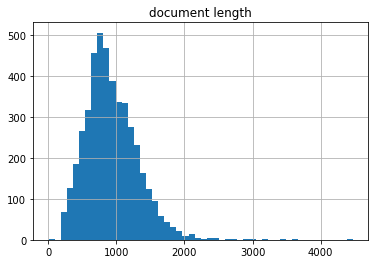

In [15]:
#document length histogram

pd.DataFrame([len(x.split()) for x in ndf['text']], columns=['document length']).hist(bins=50)

array([[<AxesSubplot:title={'center':'sentence length'}>]], dtype=object)

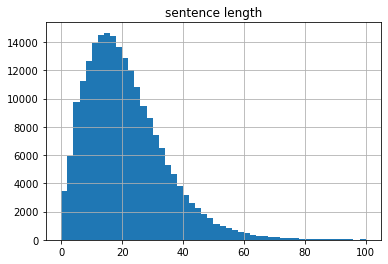

In [16]:
pd.DataFrame([len(x.split()) for x in df['text']], columns = ['sentence length']).hist(bins=50, range=(0,100))

examine other useful metrics such as top 1000 terms. 

In [17]:
words = [tokenize.word_tokenize(x) for x in corpus]
words = [y for x in words for y in x]

word_freq = pd.DataFrame(nltk.FreqDist(words).most_common(1000), columns = ['word', 'frequency'])
print(word_freq)


         word  frequency
0         the     266007
1          of     115973
2           -     114156
3          to     107951
4           a     100993
..        ...        ...
995   calling        498
996        de        498
997  strategy        497
998   numbers        496
999    lawyer        496

[1000 rows x 2 columns]


<AxesSubplot:>

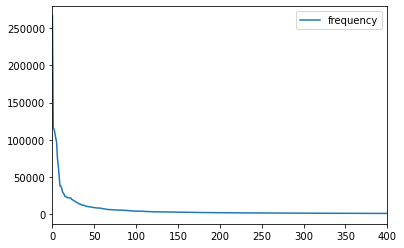

In [18]:
word_freq.plot(xlim=(0,400))

# 2 Learning Word Embeddings


skip gram model with negative sampling, followed by a GloVe model. But first, how many unique words exist in the corpus?

## 2.1 Create Dictionary of Vocabulary 

In [19]:
# Tokenize and create dictionary

class VocabWord:
    def __init__(self, word):
        self.word = word
        self.count = 0

vocab_items = []
vocab_hash = {}
word_count = 0

for token in ['<bol>', '<eol>']:
    vocab_hash[token] = len(vocab_items)
    vocab_items.append(VocabWord(token))
    
for line in df['text']:
    tokens = line.split()
    for token in tokens:
        if token not in vocab_hash:
            vocab_hash[token] = len(vocab_items)
            vocab_items.append(VocabWord(token))
            
        vocab_items[vocab_hash[token]].count +=1
        word_count += 1
        
        if word_count %1000000 == 0:
            print("\rReading word %d" % word_count)
            
    
    vocab_items[vocab_hash['<bol>']].count += 1
    vocab_items[vocab_hash['<eol>']].count += 1
    word_count += 2
    
print('Total words in training file: %d' % word_count)
print('Vocab Size: %d' % len(vocab_items))

Reading word 2000000
Reading word 3000000
Reading word 4000000
Total words in training file: 4860294
Vocab Size: 77440


## 2.2 Word2Vec

dim = dimension of word vectors
win = context window size(number of tokens)
start_alpha = starting learning rate
neg = number of samples for negative sampling
min_count = minimum number of mentions for a word to be included in vocabulary

In [20]:
# intialize parameters

dim = 100
win = 10
start_alpha = 0.05
neg = 10
min_count = 5

## 2.3 Handling Rare Words 

map vocabulary that is below the min_count threshold to out-of-vocabulary token

In [21]:
truncated = []
truncated.append(VocabWord('<unk>'))
unk_hash = 0

count_unk = 0
for token in vocab_items:
    if token.count < min_count:
        count_unk += 1
        truncated[unk_hash].count += token.count
    else:
        truncated.append(token)
        
truncated.sort(key = lambda token: token.count, reverse = True)

vocab_hash = {}

for i, token in enumerate(truncated):
    vocab_hash[token.word] = i
    
vocab_items = truncated
vocab_hash = vocab_hash
vocab_size = len(vocab_items)
print('Unknown vocab size:', count_unk)
print('Truncated vocab size: %d' % vocab_size )

Unknown vocab size: 45842
Truncated vocab size: 31599



# 2.4 Negative Sampling

create a negative sampling lookup table to use during training

In [22]:
# create a table of probabilities

power = 0.75
norm = sum([math.pow(t.count, power) for t in vocab_items])

table_size = int(1e8)
table = np.zeros(table_size, dtype=np.int)

p = 0
i = 0

for j, unigram in enumerate(vocab_items):
    p += float(math.pow(unigram.count, power))/norm
    while i < table_size and float(i)/ table_size < p:
        table[i] = j
        i += 1

def sample(table, count):
    indices = np.random.randint(low = 0, high=len(table), size = count)
    return [ table[i] for i in indices]

# 2.5 Training the Model

In [23]:
import struct

def sigmoid(z):
    if z > 6:
        return 1.0
    elif z < -6:
        return 0.0
    else:
        return 1 / (1 + math.exp(-z))
    
tmp = np.random.uniform(low = -0.5/dim, high=0.5/dim, size = (vocab_size, dim))
syn0 = np.ctypeslib.as_ctypes(tmp)
syn0 = np.array(syn0)

tmp = np.zeros(shape=(vocab_size, dim))
syn1 = np.ctypeslib.as_ctypes(tmp)
syn1 = np.array(syn1)

current_sent = 0
truncated_vocabulary = [x.word for x in vocab_items]
corpus = df['text'].tolist()

while current_sent < df.count()[0]:
#     line 
    line = corpus[current_sent]
#     current sentence, if the token is found within the truncated vocabulary list
#     then accept the token, else map it to the unknown token, and do this for every token 
#     from the begining of the line to the end of teh line(sentence)
    sent = [vocab_hash[token] if token in truncated_vocabulary else vocab_hash['<unk>']
           for token in [['<bol>'] + line.split() + ['<eol>']]]
    
#     for every sentence position at every token in the sentence
    for sent_pos, token in enumerate(sent):
        
#         randomly set the size of the current window
        current_win = np.random.randint(low=1, high=win+1)
#     must subtract so that the start of the context window is the left most context posistion
        context_start = max(sent_pos - current_win, 0)
#     must add so that the end of the context window is the right most context position
        context_end = min(sent_pos + current_win + 1, len(sent))
#     also necessary to skip over the current sentence position as this is a skip-gram model
        context = sent[context_start:sent_pos] + sent[sent_pos+1:context_end]
        
        
#         for every context word within the context window
        for context_word in context:
#         embed the word
            embed = np.zeros(DIM)
            classifiers = [(token, 1) + target[(target, 0)] for target in table.sample(neg)]
            
            for target, label in classifiers:
                
                z = np.dot(syn0[context_word], syn1[target])
                #activation function
                p = sigmoid(z)
                g = alpha * (label - p)
                embed += g * syn1[target]
                syn1[target] += g * syn0[context_word]
            syn0[context_word] += embed
            
        word_count += 1
    current_sent += 1
    if current_sent %2000 == 0:
        print('\rReading sentence %d' % current_sent)
        
embedding = dict(zip(truncated_vocabulary, syn0))
print('Trained embeddings')

# Save embeddings

fo = open("word2vec", 'w+')
for token, vector in zip(truncated_vocabulary, syn0):
    fo.write('%s' % token)
    for s in vector:
        fo.write(('%f' % s))
    fo.write('\n')
fo.close()

print(syn0.shape)

Reading sentence 2000
Reading sentence 4000
Reading sentence 6000
Reading sentence 8000
Reading sentence 10000
Reading sentence 12000
Reading sentence 14000
Reading sentence 16000
Reading sentence 18000
Reading sentence 20000
Reading sentence 22000
Reading sentence 24000
Reading sentence 26000
Reading sentence 28000
Reading sentence 30000
Reading sentence 32000
Reading sentence 34000
Reading sentence 36000
Reading sentence 38000
Reading sentence 40000
Reading sentence 42000
Reading sentence 44000
Reading sentence 46000
Reading sentence 48000
Reading sentence 50000
Reading sentence 52000
Reading sentence 54000
Reading sentence 56000
Reading sentence 58000
Reading sentence 60000
Reading sentence 62000
Reading sentence 64000
Reading sentence 66000
Reading sentence 68000
Reading sentence 70000
Reading sentence 72000
Reading sentence 74000
Reading sentence 76000
Reading sentence 78000
Reading sentence 80000
Reading sentence 82000
Reading sentence 84000
Reading sentence 86000
Reading sentenc

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([embedding['man']], [embedding['woman']]))
print(cosine_similarity([embedding['candy']], [embedding['social']]))

[[-0.03592961]]
[[-0.11941387]]


## 2.6 Visualize Embedding space 

use tsne to map embeddings to a 2d space. This is preferrable to another algorithm such as PCA because tSNE preserves local small pairwise distances or local similarities as opposed to PCA which maximizes variance 

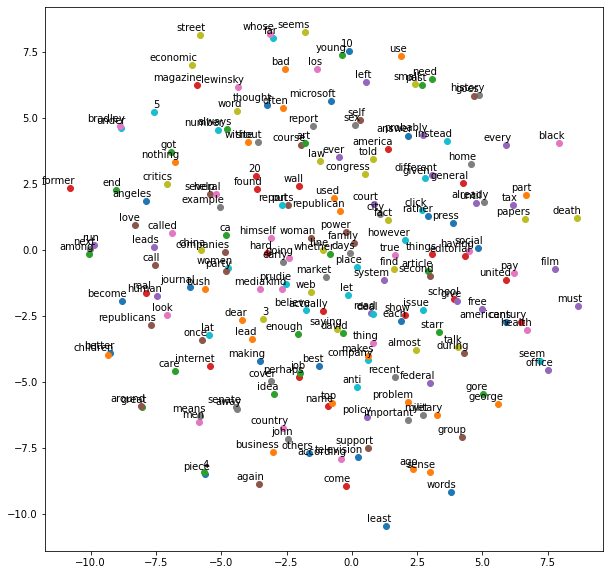

In [25]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = truncated_vocabulary[200:400]
embeddings = syn0
words_embedded = TSNE(n_components = 2).fit_transform(embeddings[200:400])

pylab.figure(figsize=(10,10))
for i, label in enumerate(words):
    x, y = words_embedded[i,:]
    pylab.scatter(x,y)
    pylab.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points',
                  ha='right', va='bottom')
pylab.show()

In [26]:
from collections import Counter

vocab_count = Counter()

for line in corpus:
    tokens = line.strip().split()
    vocab_count.update(tokens)
    
vocab = {word: (i, freq) for i, (word, freq) in enumerate(vocab_count.items())}

## 2.10 Co-occurence matrix 

In [27]:
from scipy import sparse

min_count = 10
window_size = 5

vocab_size = len(vocab)
id2word = dict((i, word) for word, (i, _) in vocab.items())
occurrence = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)

for i, line in enumerate(corpus):
    tokens = line.split()
    token_ids = [vocab[word][0] for word in tokens]

    for center_i, center_id in enumerate(token_ids):
        # Collect all word IDs in left window of center word
        context_ids = token_ids[max(0, center_i - window_size) : center_i]
        contexts_len = len(context_ids)

        for left_i, left_id in enumerate(context_ids):
            # Distance from center word
            distance = contexts_len - left_i

            # Weight by inverse of distance between words
            increment = 1.0 / float(distance)

            # Build co-occurrence matrix symmetrically (pretend we
            # are calculating right contexts as well)
            occurrence[center_id, left_id] += increment
            occurrence[left_id, center_id] += increment
    if i % 10000 == 0:
        print("Processing sentence %d" % i)

# Create a generator for efficient calculation

def occur_matrix(vocab, coccurrence, min_count):
  for i, (row, data) in enumerate(zip(coccurrence.rows, coccurrence.data)):
    if min_count is not None and vocab[id2word[i]][1] < min_count:
        continue

    for data_idx, j in enumerate(row):
        if min_count is not None and vocab[id2word[j]][1] < min_count:
            continue

        yield i, j, data[data_idx]

print("Creating co-occurrence matrix generator")
comatrix = occur_matrix(vocab, occurrence, min_count)

Processing sentence 0
Processing sentence 10000
Processing sentence 20000
Processing sentence 30000
Processing sentence 40000
Processing sentence 50000
Processing sentence 60000
Processing sentence 70000
Processing sentence 80000
Processing sentence 90000
Processing sentence 100000
Processing sentence 110000
Processing sentence 120000
Processing sentence 130000
Processing sentence 140000
Processing sentence 150000
Processing sentence 160000
Processing sentence 170000
Processing sentence 180000
Processing sentence 190000
Processing sentence 200000
Processing sentence 210000
Creating co-occurrence matrix generator


## 2.11 GloVe Training 

In [28]:
from random import shuffle
from math import log
import pickle

iterations = 30
dim = 100
learning_rate = 0.05
x_max = 100
alpha = 0.75

vocab_size = len(vocab)
W = (np.random.rand(vocab_size * 2, dim) - 0.5) / float(dim + 1)
biases = (np.random.rand(vocab_size * 2) - 0.5) / float(dim + 1)

gradient_squared = np.ones((vocab_size * 2, dim), dtype=np.float64)
gradient_squared_biases = np.ones(vocab_size * 2, dtype=np.float64)

data = [(W[i_main], W[i_context + vocab_size],
             biases[i_main : i_main + 1],
             biases[i_context + vocab_size : i_context + vocab_size + 1],
             gradient_squared[i_main], gradient_squared[i_context + vocab_size],
             gradient_squared_biases[i_main : i_main + 1],
             gradient_squared_biases[i_context + vocab_size
                                     : i_context + vocab_size + 1],
             cooccurence)
            for i_main, i_context, cooccurrence in comatrix]

for i in range(iterations):
    global_cost = 0
    shuffle(data)
    for (v_main, v_context, b_main, b_context, gradsq_W_main, gradsq_W_context,
         gradsq_b_main, gradsq_b_context, cooccurrence) in data:

        weight = (cooccurrence / x_max) ** alpha if cooccurrence < x_max else 1

        cost_inner = (v_main.dot(v_context)
                      + b_main[0] + b_context[0]
                      - log(cooccurrence))
        cost = weight * (cost_inner ** 2)
        global_cost += 0.5 * cost

        grad_main = weight * cost_inner * v_context
        grad_context = weight * cost_inner * v_main
        grad_bias_main = weight * cost_inner
        grad_bias_context = weight * cost_inner

        v_main -= (learning_rate * grad_main / np.sqrt(gradsq_W_main))
        v_context -= (learning_rate * grad_context / np.sqrt(gradsq_W_context))

        b_main -= (learning_rate * grad_bias_main / np.sqrt(gradsq_b_main))
        b_context -= (learning_rate * grad_bias_context / np.sqrt(
                gradsq_b_context))

        gradsq_W_main += np.square(grad_main)
        gradsq_W_context += np.square(grad_context)
        gradsq_b_main += grad_bias_main ** 2
        gradsq_b_context += grad_bias_context ** 2
    print('iteration = ',i,' cost = ',global_cost)
    
# Save model

with open("glove","wb") as f:
    pickle.dump(W, f, protocol=2)

NameError: name 'cooccurence' is not defined

In [29]:

def merge_vectors(W, merge_fun=lambda m, c: np.mean([m, c], axis=0)):

    vocab_size = int(len(W) / 2)
    for i, row in enumerate(W[:vocab_size]):
        merged = merge_fun(row, W[i + vocab_size])
        merged /= np.linalg.norm(merged)
        W[i, :] = merged

    return W[:vocab_size]

embedding = merge_vectors(W)
len(embedding)

77438

## 2.12 GloVe Vector Similarity 

In [30]:
def most_similar(W, vocab, id2word, word, n=5):
    """
    Find the `n` words most similar to the given `word`. The provided
    `W` must have unit vector rows, and must have merged main- and
    context-word vectors (i.e., `len(W) == len(word2id)`).
    Returns a list of word strings.
    """

    assert len(W) == len(vocab)

    word_id = vocab[word][0]

    dists = np.dot(W, W[word_id])
    top_ids = np.argsort(dists)[::-1][:n + 1]

    return [(id2word[id],dists[id]) for id in top_ids if id != word_id][:n]

for term in most_similar(embedding, vocab, id2word, 'man', 5): print(term)

('handfasting', 0.48498454781294004)
('strives', 0.443439075823133)
('underlay', 0.4122300420603452)
('translucency', 0.3915092085224538)
('peacekeeping', 0.3810540024336728)


# Using Glove Package

In [33]:
%pip install glove-python-binary
import gensim
from glove import Corpus, Glove
documents = [gensim.utils.simple_preprocess(df['text'].iloc[i]) for i in range(len(df))]

Note: you may need to restart the kernel to use updated packages.


In [34]:
corpus = Corpus()

corpus.fit(documents, window=5)

In [37]:
documents = [gensim.utils.simple_preprocess(ndf['text'].iloc[i]) for i in range(len(ndf))]
corpus.fit(documents, window=5)
glove = Glove(no_components=100, learning_rate = 0.05)
glove.fit(corpus.matrix, epochs = 10, no_threads=4, verbose = True)
glove.add_dictionary(corpus.dictionary)
print("Glove embeddings trained.")

doc_vectors = []
for doc in documents:
    vec = np.zeros(glove.word_vectors[glove.dictionary['the']].shape)
    for token in doc:
        vec += glove.word_vectors[glove.dictionary[token]]
    if len(doc) > 0:
        vec = vec/len(doc)
    doc_vectors.append(vec)
    
print("Processed documents = ", len(doc_vectors))

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Glove embeddings trained.
Processed documents =  4531


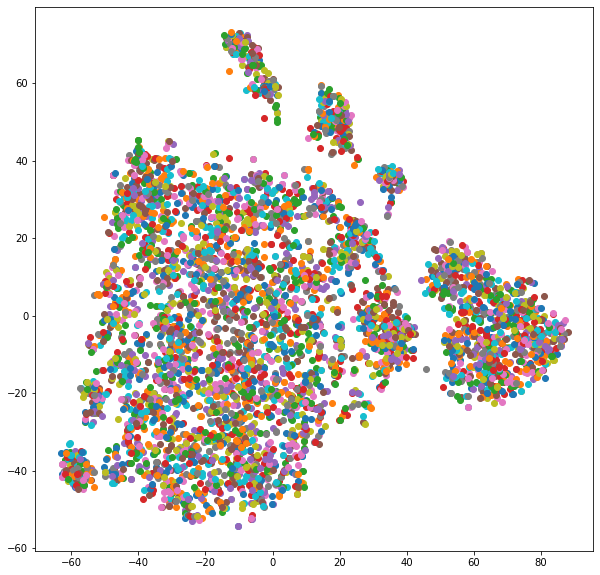

In [38]:
from sklearn.manifold import TSNE
from matplotlib import pylab

docs_embedded = TSNE(n_components=2).fit_transform(doc_vectors)

pylab.figure(figsize=(10,10))
for i, label in enumerate(docs_embedded):
    x, y = docs_embedded[i, :]
    pylab.scatter(x,y)
pylab.show()

# 4.1 Load spaCy

In [44]:
%pip install spacy

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

print('Model loaded')


Model loaded


# 4.2 Supervised Disambiguation Annotations

In [45]:


corpus = df['text'].tolist()
print("Number of docs = ",len(corpus))

docs = []
count = 0
for item in corpus:
  docs.append(nlp(item))
  count += 1
  if count % 10000 == 0:
    print("Processed document #",count)



Number of docs =  214225
Processed document # 10000
Processed document # 20000
Processed document # 30000
Processed document # 40000
Processed document # 50000
Processed document # 60000
Processed document # 70000
Processed document # 80000
Processed document # 90000
Processed document # 100000
Processed document # 110000
Processed document # 120000
Processed document # 130000
Processed document # 140000
Processed document # 150000
Processed document # 160000
Processed document # 170000
Processed document # 180000
Processed document # 190000
Processed document # 200000
Processed document # 210000


# 4.3 POS Label Annotation

In [46]:
sense_corpus = [[x.text+"_"+x.pos_ for x in y] for y in docs]
print(corpus[0])
print(' '.join(sense_corpus[0]))

harmonic convergences you are right maxim strong point is that it totally unsentimental and ungenteel 
harmonic_ADJ convergences_NOUN you_PRON are_VERB right_ADJ maxim_NOUN strong_ADJ point_NOUN is_VERB that_SCONJ it_PRON totally_ADV unsentimental_ADJ and_CCONJ ungenteel_ADJ


# Train with word2vec

In [48]:
model = gensim.models.Word2Vec(sense_corpus,
                                size=100,
                                window=10,
                                min_count=2,
                                workers=10)
model.train(sense_corpus, total_examples=len(sense_corpus), epochs=10)

(34864968, 44598130)

# Evaluate Word Sense Disambiguation

In [49]:
model.wv.most_similar("run_NOUN", topn=5)

[('runs_NOUN', 0.6228179931640625),
 ('term_NOUN', 0.5132395029067993),
 ('season_NOUN', 0.5129913091659546),
 ('round_NOUN', 0.48910781741142273),
 ('sosa_NOUN', 0.4614245295524597)]

In [50]:
model.wv.most_similar("run_VERB", topn=5)

[('break_VERB', 0.618589460849762),
 ('running_VERB', 0.5952342748641968),
 ('weigh_VERB', 0.589073657989502),
 ('compete_VERB', 0.5886638164520264),
 ('put_VERB', 0.5885495543479919)]

In [51]:
model.wv.most_similar("lie_NOUN", topn=5)

[('harrassment_NOUN', 0.5774683952331543),
 ('truth_NOUN', 0.5745654106140137),
 ('offense_NOUN', 0.5607261657714844),
 ('perjury_NOUN', 0.5570409297943115),
 ('sin_NOUN', 0.5442428588867188)]

In [52]:
model.wv.most_similar("lie_VERB", topn=5)

[('talk_VERB', 0.641007661819458),
 ('testify_VERB', 0.6285200119018555),
 ('commit_VERB', 0.5791645646095276),
 ('cooperate_VERB', 0.5691736936569214),
 ('sleep_VERB', 0.5671057105064392)]